<a href="https://colab.research.google.com/github/adrian-lison/gnn-community-detection/blob/master/Notebooks/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K means


In [1]:
!pip install dgl

In [0]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

In [3]:
data = citegrh.load_cora()
g_original = data.graph

Extracting file to /root/.dgl/cora


In [4]:
#Here, no directions are given (?) / maintained
edges_per_node = {}
for x in g_original.adj.items():
  z = [] 
  for i in x[1]:
    z.append(i)
  edges_per_node[x[0]] = z
edges_per_node[0]
len(edges_per_node)

2708

In [0]:
from scipy.sparse import lil_matrix
matrix_all = lil_matrix((g_original.number_of_nodes(),g_original.number_of_edges()))
for i in range(len(edges_per_node)):
  matrix_all[i,edges_per_node[i]] = 1

In [0]:
matrix_all = lil_matrix((g_original.number_of_nodes(),g_original.number_of_edges()))
for e in g_original.edges:
    matrix_all[e[0],e[1]] = 1

In [7]:
#Dimensionality Reduction with SVD
amount_features = 5 # Amount dimensions
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
X = matrix_all.transpose()
svd = TruncatedSVD(n_components=amount_features, n_iter=1000)
svd.fit(X)  


print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

print(svd.singular_values_)  

[0.01932718 0.01443322 0.01270968 0.00887954 0.00799841]
0.06334802264663704
[14.39092445 12.36582663 11.63854942  9.72217631  9.20595631]


In [0]:
a = svd.fit(X)  

In [9]:
array_components_per_node = []
for x in range(a.components_.shape[1]): #Amount edges
    row_node = []
    for y in range(a.components_.shape[0]): #Amount components
        row_node.append(a.components_[y][x])
    array_components_per_node.append(row_node)
len(array_components_per_node)

2708

In [10]:
from sklearn.cluster import KMeans
import numpy as np
X = array_components_per_node
kmeans = KMeans(n_clusters=7).fit(X)
kmeans.labels_
kmeans.cluster_centers_

array([[ 9.15385362e-04, -4.88388433e-04,  1.14620633e-03,
         1.42535505e-03, -1.60125855e-04],
       [ 5.58400143e-02,  5.26275275e-02, -5.11376116e-03,
        -1.62211527e-04, -4.62086249e-04],
       [ 1.32889387e-02, -1.09724065e-02,  7.48738686e-02,
         4.36384146e-01, -4.26497346e-01],
       [ 6.54341564e-01, -7.14096678e-01, -6.20254077e-02,
        -6.37992853e-03,  1.04685633e-02],
       [ 2.23736372e-02, -3.32784512e-03,  2.97147718e-01,
        -3.66615390e-02, -1.23524582e-01],
       [ 1.62203326e-03,  6.48402530e-04,  1.24428566e-02,
         5.76568730e-02,  5.32018383e-02],
       [ 6.38245362e-03,  4.23913490e-04,  7.18676061e-02,
        -1.69066257e-02,  2.60681569e-02]])

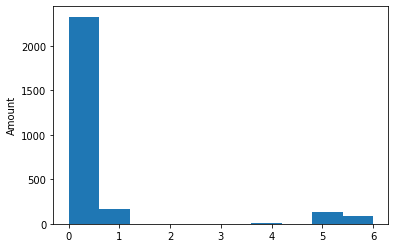

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = kmeans.labels_
plt.hist(x)
plt.ylabel('Amount');